# LSTM
Try sequence-of-Kmers.

In [20]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-11-21 12:55:20.559945
Python 3.7.15
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [21]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
#from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=3
EPOCHS=10
FOLDS=5  
BREAK = False   # break after first fold
MAXLEN=4000   # this is problematic as some genes will be excluded entirely or partially
MINLEN=1000

In [22]:
try:
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
print(DATA_DIR)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/


In [23]:
GENES_FILE =    'CNRCI_noncoding_train_genes.csv'
RCI_FILE =      'CNRCI_noncoding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_noncoding_train_transcripts.gc42.csv'
COUNTS_FILE=    'CNRCI_noncoding_train_counts.K4.gc42.csv'

In [24]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
CELL_LINE_NUMBER=1
all_cell_lines = get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 1 = H1.hESC


## Data Load

In [25]:
print(datetime.now())
# labels
filepath = DATA_DIR+RCI_FILE
gene_to_rci = {}
with open (filepath,'r') as handle:
    header = None
    for row in handle:
        if header is None:
            header = row
        else:
            line = row.strip()
            fields = line.split(',')
            gene_id = fields[0]
            rci_val = fields[CELL_LINE_NUMBER+1]
            # Could implement Gudenas style threshold here
            if rci_val != "nan":
                gene_to_rci[gene_id] = float(rci_val)
print('Num RCI:', len(gene_to_rci.keys()))
print(list(gene_to_rci.items())[:3])
all_genes = list(gene_to_rci.keys())

2022-11-21 12:55:21.967146
Num RCI: 3327
[('ENSG00000099869', 1.0), ('ENSG00000116652', 1.65208), ('ENSG00000117242', -0.793877)]


In [26]:
def seq_to_kmers(rna,K):
    VALS = {'A':0, 'C':1, 'G':2, 'T':3, 'N':0}
    length = len(rna)
    vec = []
    for i in range(length-K+1):
        one_hot = 0
        for j in range(K):
            one_hot = one_hot * 4
            nextnuc = rna[i+j]
            if nextnuc=='N':
                one_hot= 0   # Same as A? Come back to this and try mask_zero=True
                break
            nucval = VALS[nextnuc]
            one_hot = one_hot + nucval
        vec.append(one_hot)
    return vec
print(seq_to_kmers('AAAA',3))
print(seq_to_kmers('CATT',3))
print(seq_to_kmers('TTGA',3))
print(seq_to_kmers('TTTN',3))

[0, 0]
[19, 15]
[62, 56]
[63, 0]


In [27]:
# one hot
print(datetime.now())
print('Load sequence')
filepath = DATA_DIR+SEQUENCE_FILE
labels=[]
allids=[]
allseq=[]
NREPEAT = str('N'*MAXLEN)
with open (filepath,'r') as handle:
    header = None
    for row in handle:
        if header is None:
            header = row
        else:
            line    = row.strip()
            fields  = line.split(',')
            tran_id = fields[0]  # with version number
            gene_id = fields[1]        # without version number
            seq_len = int(fields[3])
            seq_txt = fields[4]
            if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                rci_val = gene_to_rci[gene_id]
                allids.append( (gene_id,tran_id) )
                labels.append(rci_val)
                if seq_len<MAXLEN:
                    seq_txt = seq_txt + NREPEAT
                    seq_txt = seq_txt[:MAXLEN]
                hot_vec = seq_to_kmers(seq_txt,K)
                allseq.append(hot_vec)
print(datetime.now())
print('Num IDs:',len(allids))
#print('Examples:',[allids[x] for x in [10, 20, 30, 40]] )
print('Num labels:',len(labels))
#print('Examples:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num counts:',len(allseq))
#print('Example:',allseq[3])

2022-11-21 12:55:22.055024
Load sequence
2022-11-21 12:55:43.287866
Num IDs: 8564
Num labels: 8564
Num counts: 8564


In [28]:
def get_gene_subset(all_genes,sub_index):
    sub_genes = set()
    for index in sub_index:
        one_gene = all_genes[index]
        sub_genes.add(one_gene)
    return sub_genes
def get_X_y(gene_set,allids,allX,allY,threshold):
    cnt = len(allids)
    subsetX=[]
    subsetY=[]
    if cnt != len(allX) or cnt!= len(allY):
        raise Exception('Lengths differ')
    for i in range(cnt):
        gene_id,tran_id = allids[i]
        if gene_id in gene_set:
            oneX = allX[i]
            oneY = allY[i]
            if oneY < threshold:
                Yvalue = int(0)
            else:
                Yvalue = int(1)
            subsetX.append(oneX)
            subsetY.append(Yvalue)
    subsetX = np.array(subsetX)
    subsetY = np.array(subsetY).reshape((-1,1))
    return subsetX,subsetY

In [29]:
def build_model():
    ALPHABET=4**K  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    EMBED_DIMEN = 16 # arbitrary hyperparameter
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    rnn = Sequential()
    # This layer automatically converts inputs to one-hot using alphabet size.
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,mask_zero=False);   # crashes with mask_value=True
    # rnn1_layer = LSTM(16, return_sequences=True, input_shape=[MAXLEN,DIMEN]) 
    rnn1_layer = Bidirectional( LSTM(32, return_sequences=True) )
    # rnn1_layer = LSTM(16, return_sequences=True) 
    # rnn2_layer = LSTM(16, return_sequences=True)
    # Dense can handle sequence input. Is it the best thing to do?
    dense1_layer = Dense(16,activation='sigmoid',dtype=dt)
    dropout1_layer = Dropout(0.50)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    rnn.add(embed_layer)
    rnn.add(rnn1_layer)
    #rnn.add(rnn2_layer)
    rnn.add(dense1_layer)
    rnn.add(dropout1_layer)
    #rnn.add(dense2_layer)
    rnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [30]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once

2022-11-21 12:55:43.335593
COMPILE
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          1024      
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 64)         12544     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, None, 16)          1040      
                                                                 
 dropout_2 (Dropout)         (None, None, 16)          0         
                                                                 
 dense_5 (Dense)             (None, None, 1)           17        
                                                                 
Total params: 14,625
Trainable params: 14,625
Non-trainable params: 0
_______________

In [31]:
SCALING = False
def do_cross_validation(eps):
    cv_scores = []
    fold=0
    print(datetime.now())
    print('splitting')
    # KFold shuffles once before making the partitions
    splitter = KFold(n_splits=FOLDS,shuffle=True,random_state=42)
    for train_index,valid_index in splitter.split(all_genes):
        fold += 1
        print('Fold',fold)
        train_genes = get_gene_subset(all_genes,train_index)
        valid_genes = get_gene_subset(all_genes,valid_index)
        X_train,y_train = get_X_y(train_genes,allids,allseq,labels,0)
        X_valid,y_valid = get_X_y(valid_genes,allids,allseq,labels,0)

        if SCALING:
            print('scaling')
            print(datetime.now())
            scaler = StandardScaler()
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            X_valid = scaler.transform(X_valid)

        print('Train sizes',X_train.shape,y_train.shape)
        print('Valid sizes',X_valid.shape,y_valid.shape)
        print('Train set ones/size',
              np.count_nonzero(y_train),'/',len(y_train))
        print('Valid set ones/size',
              np.count_nonzero(y_valid),'/',len(y_valid))

        print("BUILD MODEL")
        model=build_model()

        print("FIT")
        print(datetime.now())
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                validation_data=(X_valid,y_valid) )

        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()

        print("Compute valiation accuracy")
        print(datetime.now())
        scores = model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        print(datetime.now())
        cv_scores.append(scores[1] * 100)
        
        if BREAK:
            break
        
    print()
    return cv_scores
print(datetime.now())

2022-11-21 12:55:44.391237


Issues to address:

Reduce dtype to int8?
Call arguments received by layer "sequential" "                 f"(type Sequential):
inputs=tf.Tensor(shape=(None, 4000, 4), dtype=int32)

The genes were shuffled but the transcripts were not.  
That could retard training.

Loading sequence takes minutes. Save one-hot dataset to binary file. 

Loading sequence takes RAM. A numpy array of one-hot might require less RAM. Write a just-in-time loader.

Accuracy goes down at the start of each epoch. This could mean that the data are not shuffled sufficiently.

2022-11-21 12:55:44.408956
2022-11-21 12:55:44.410956
splitting
Fold 1
Train sizes (6777, 3998) (6777, 1)
Valid sizes (1787, 3998) (1787, 1)
Train set ones/size 2754 / 6777
Valid set ones/size 765 / 1787
BUILD MODEL
COMPILE
FIT
2022-11-21 12:55:46.690537
Epoch 1/10
212/212 [==============================] - 51s 227ms/step - loss: 0.6877 - accuracy: 0.5774 - val_loss: 0.6845 - val_accuracy: 0.5719
Epoch 2/10
212/212 [==============================] - 47s 220ms/step - loss: 0.6774 - accuracy: 0.5934 - val_loss: 0.6840 - val_accuracy: 0.5719
Epoch 3/10
212/212 [==============================] - 47s 220ms/step - loss: 0.6774 - accuracy: 0.5936 - val_loss: 0.6828 - val_accuracy: 0.5719
Epoch 4/10
212/212 [==============================] - 47s 222ms/step - loss: 0.6767 - accuracy: 0.5936 - val_loss: 0.6816 - val_accuracy: 0.5719
Epoch 5/10
212/212 [==============================] - 47s 222ms/step - loss: 0.6752 - accuracy: 0.5936 - val_loss: 0.6822 - val_accuracy: 0.5719
Epoch 6/10
212/212 [

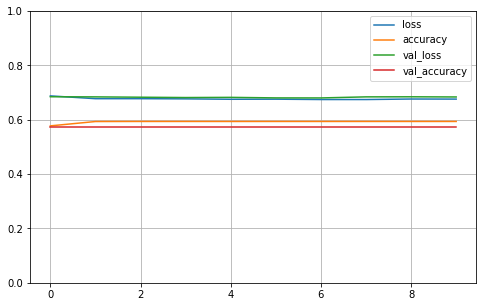

Compute valiation accuracy
2022-11-21 13:03:40.105550
accuracy: 57.19%
2022-11-21 13:03:45.234300
Fold 2
Train sizes (6893, 3998) (6893, 1)
Valid sizes (1671, 3998) (1671, 1)
Train set ones/size 2899 / 6893
Valid set ones/size 620 / 1671
BUILD MODEL
COMPILE
FIT
2022-11-21 13:03:47.536898
Epoch 1/10
216/216 [==============================] - 51s 219ms/step - loss: 0.6905 - accuracy: 0.5649 - val_loss: 0.6724 - val_accuracy: 0.6290
Epoch 2/10
216/216 [==============================] - 47s 220ms/step - loss: 0.6821 - accuracy: 0.5793 - val_loss: 0.6640 - val_accuracy: 0.6290
Epoch 3/10
216/216 [==============================] - 47s 219ms/step - loss: 0.6819 - accuracy: 0.5794 - val_loss: 0.6676 - val_accuracy: 0.6290
Epoch 4/10
216/216 [==============================] - 47s 219ms/step - loss: 0.6818 - accuracy: 0.5794 - val_loss: 0.6701 - val_accuracy: 0.6290
Epoch 5/10
216/216 [==============================] - 46s 214ms/step - loss: 0.6811 - accuracy: 0.5794 - val_loss: 0.6616 - val_acc

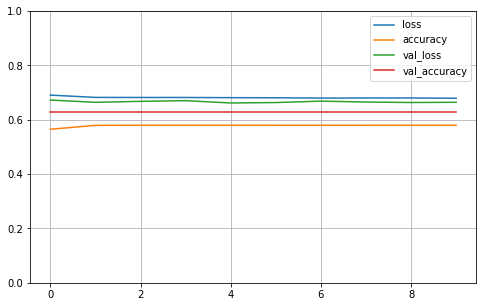

Compute valiation accuracy
2022-11-21 13:11:44.295229
accuracy: 62.90%
2022-11-21 13:11:49.107399
Fold 3
Train sizes (7029, 3998) (7029, 1)
Valid sizes (1535, 3998) (1535, 1)
Train set ones/size 2994 / 7029
Valid set ones/size 525 / 1535
BUILD MODEL
COMPILE
FIT
2022-11-21 13:11:51.334485
Epoch 1/10
220/220 [==============================] - 52s 221ms/step - loss: 0.7034 - accuracy: 0.5460 - val_loss: 0.6568 - val_accuracy: 0.6580
Epoch 2/10
220/220 [==============================] - 48s 219ms/step - loss: 0.6840 - accuracy: 0.5730 - val_loss: 0.6577 - val_accuracy: 0.6580
Epoch 3/10
220/220 [==============================] - 48s 218ms/step - loss: 0.6837 - accuracy: 0.5740 - val_loss: 0.6611 - val_accuracy: 0.6580
Epoch 4/10
220/220 [==============================] - 47s 213ms/step - loss: 0.6832 - accuracy: 0.5740 - val_loss: 0.6580 - val_accuracy: 0.6580
Epoch 5/10
220/220 [==============================] - 48s 217ms/step - loss: 0.6829 - accuracy: 0.5740 - val_loss: 0.6625 - val_acc

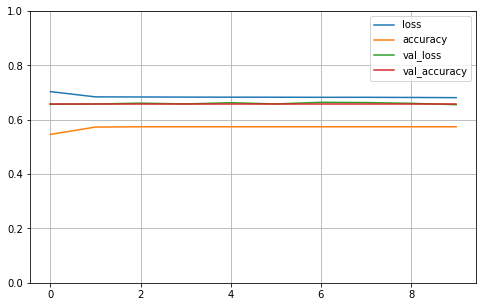

Compute valiation accuracy
2022-11-21 13:19:53.140034
accuracy: 65.80%
2022-11-21 13:19:57.502399
Fold 4
Train sizes (6732, 3998) (6732, 1)
Valid sizes (1832, 3998) (1832, 1)
Train set ones/size 2666 / 6732
Valid set ones/size 853 / 1832
BUILD MODEL
COMPILE
FIT
2022-11-21 13:19:59.736817
Epoch 1/10
211/211 [==============================] - 52s 229ms/step - loss: 0.6909 - accuracy: 0.5796 - val_loss: 0.6983 - val_accuracy: 0.5344
Epoch 2/10
211/211 [==============================] - 46s 220ms/step - loss: 0.6743 - accuracy: 0.6037 - val_loss: 0.6951 - val_accuracy: 0.5344
Epoch 3/10
211/211 [==============================] - 47s 225ms/step - loss: 0.6736 - accuracy: 0.6040 - val_loss: 0.6958 - val_accuracy: 0.5344
Epoch 4/10
211/211 [==============================] - 48s 226ms/step - loss: 0.6730 - accuracy: 0.6040 - val_loss: 0.6950 - val_accuracy: 0.5344
Epoch 5/10
211/211 [==============================] - 48s 226ms/step - loss: 0.6728 - accuracy: 0.6040 - val_loss: 0.7007 - val_acc

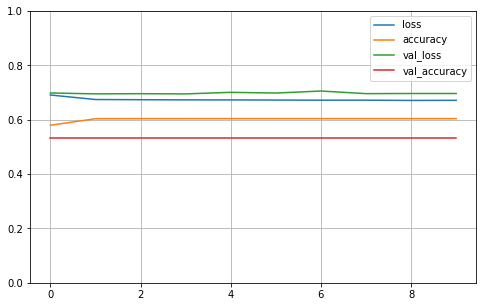

Compute valiation accuracy
2022-11-21 13:27:56.578247
accuracy: 53.44%
2022-11-21 13:28:01.727826
Fold 5
Train sizes (6825, 3998) (6825, 1)
Valid sizes (1739, 3998) (1739, 1)
Train set ones/size 2763 / 6825
Valid set ones/size 756 / 1739
BUILD MODEL
COMPILE
FIT
2022-11-21 13:28:03.925016
Epoch 1/10
214/214 [==============================] - 51s 222ms/step - loss: 0.6928 - accuracy: 0.5797 - val_loss: 0.6853 - val_accuracy: 0.5653
Epoch 2/10
214/214 [==============================] - 47s 219ms/step - loss: 0.6774 - accuracy: 0.5950 - val_loss: 0.6846 - val_accuracy: 0.5653
Epoch 3/10
214/214 [==============================] - 47s 220ms/step - loss: 0.6765 - accuracy: 0.5951 - val_loss: 0.6850 - val_accuracy: 0.5653
Epoch 4/10
214/214 [==============================] - 46s 216ms/step - loss: 0.6759 - accuracy: 0.5952 - val_loss: 0.6841 - val_accuracy: 0.5653
Epoch 5/10
214/214 [==============================] - 47s 222ms/step - loss: 0.6753 - accuracy: 0.5951 - val_loss: 0.6829 - val_acc

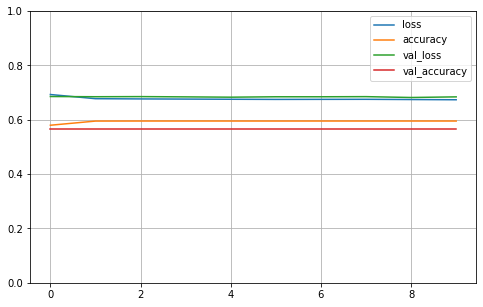

Compute valiation accuracy
2022-11-21 13:35:58.138296
accuracy: 56.53%
2022-11-21 13:36:02.973783

Cross validation acc mean 59.17% (+/- 4.51%)
2022-11-21 13:36:02.975581


In [32]:
print(datetime.now())
cv_scores = do_cross_validation(EPOCHS)    
print("Cross validation acc mean %.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))
print(datetime.now())